# **Word2Vec**

## 학습 목표
1. Word2Vec 모델 구조를 이해하고 구현한다.
2. 실제 데이터로 학습해보고 결과를 확인한다.
3. 임베딩 벡터의 시각화를 통해 정성적인 평가를 한다.

**Context**
1. Word2Vec (CBOW, Skip-Gram) 모델 구현하기
2. Word2Vec 학습 및 추론하기
3. Gensim 패키지를 활용해 Word Embedding을 시각화하여 분석하기

##0. 필요한 패키지 및 라이브러리 import

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import string
import numpy as np
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm import tqdm

## 1. Word2Vec (CBOW, Skip-Gram) 모델 구현하기

> 💡 Word2Vec 이란❓
>
> 단어를 벡터로 변환하는 기법 중 하나로써 [Efficient Estimation of Word Representations in Vector Space (Mikolov et al., 2013)](https://arxiv.org/pdf/1301.3781.pdf) 논문에서 공개되었다.
>
> 단어를 벡터화 하는 방법 중 가장 간단한 방법은 **희소 표현(sparse representation)**을 쓰는 것인데, 표현하고자 하는 단어의 인덱스의 값만 1이고 나머지 단어들의 인덱스 값은 0인 one-hot 벡터를 활용한다. 하지만 이러한 표현 방법은 단어 벡터 간의 유사성을 표현할 수 없다는 치명적인 단점이 있다.
>
> 단어 벡터 간의 유사성을 표현하기 위해 나온 것이 바로 **분산 표현(distributed representation)**이고, 이를 위한 대표적인 학습 방법이 Word2Vec이다. 단어를 그저 one-hot 벡터로 표현하는 것이 아닌, 비슷한 문맥에서 등장하는 단어들을 유사한 벡터값을 가지도록 학습한다.
>
> Word2Vec의 학습 방식은 CBOW (Continuous Bag of Words)와 Skip-Gram으로 나뉜다. **CBOW**는 주변 단어들을 입력으로 주었을 때 중간에 있는 단어를 예측하도록 학습하는 반면, **Skip-Gram**은 중간에 있는 단어를 입력으로 주변 단어들을 예측하도록 학습한다.
>
> 지금부터 CBOW와 Skip-Gram 모델을 구현하면서 각 모델을 좀 더 자세히 살펴보고자 한다.

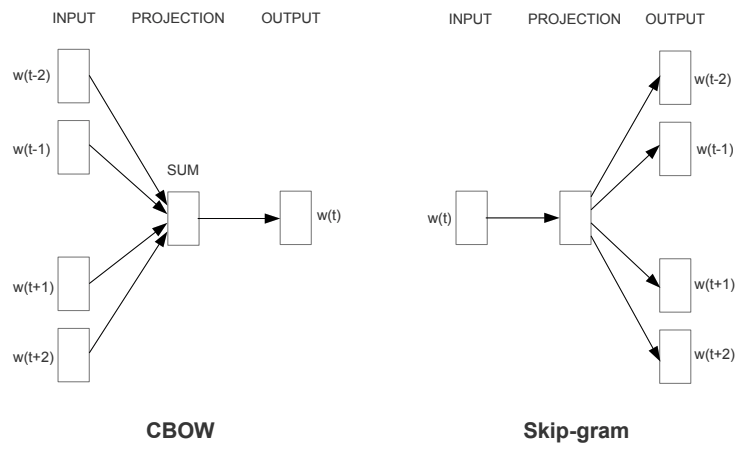


### 1-1. 데이터 전처리

> 데이터를 확인하고 Word2Vec 형식에 맞게 전처리한다.

In [ ]:
raw_text = "In the first place we have granted to God, and by this our present charter confirmed for us " + \
"and our heirs forever that the English Church shall be free, and shall have her rights entire, and her " + \
"liberties inviolate; and we will that it be thus observed; which is apparent from this that the freedom " + \
"of elections, which is reckoned most important and very essential to the English Church, we, of our pure " + \
"and unconstrained will, did grant, and did by our charter confirm and did obtain the ratification of the " + \
"same from our lord, Pope Innocent III, before the quarrel arose between us and our barons: and this we " + \
"will observe, and our will is that it be observed in good faith by our heirs forever. We have also granted " + \
"to all freemen of our kingdom, for us and our heirs forever, all the underwritten liberties, to be had " + \
"and held by them and their heirs, of us and our heirs forever."

> 구두점(punctuations)을 제거하는 간단한 전처리를 진행한다.
>
> 구두점을 미리 제거해야 하는 이유는 텍스트를 단어 단위로 쪼갤 때 제대로 처리되지 못할 수 있기 때문이다.
>
> 예를 들어 쉼표가 붙어있는 "forever,"과 온점이 붙어있는 "forever."은 같은 단어이지만 구두점을 제대로 처리하지 않으면 모델은 다른 단어로 인식한다.

> 어떤 특수문자를 구두점으로 정의할 지는 사용자가 정할 수 있지만, 본 실습에서는 Python의 내장 모듈 `string`에서 정의된 구두점들을 불러온다.
>
> ➡️ ```string.punctuation```: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

> `raw_text`에서 `string.punctuation`에 정의된 기호 중에 하나라도 매치가 되면 해당 기호를 지운다.
>
> 이를 위해 Python 내장 함수 `translate()`과 `str.maketrans()`를 활용한다.
>
> `translate()` 함수는 문자를 다른 문자로 바꿀 때 혹은 특정 문자를 지울 때 사용하게 되는데, mapping table을 파라미터로 받게 되고 이 mapping table은 `str.maketrans()`를 통해 만들 수 있다.
>
> `str.maketrans(x, y, z)`는 세 가지 파라미터 (x, y, z)를 받는데, `x`의 문자들을 `y`의 문자들로 대체하고 `z`에 해당하는 문자들은 지운다.

```
💻 예시

text = "word2vec tutorial!"
mapping_table = str.maketrans("2", "4", "!")

>> print(text.translate(mapping_table))
>> word4vec tutorial
```

In [ ]:
# x와 y가 각각 '' (empty string)이기 때문에 아무 문자도 변환하지 않는다.
# z, 즉 string.punctuation에 해당하는 문자들만 지운다.
preprocessed_text = raw_text.translate(str.maketrans('', '', string.punctuation))
print(preprocessed_text)

In the first place we have granted to God and by this our present charter confirmed for us and our heirs forever that the English Church shall be free and shall have her rights entire and her liberties inviolate and we will that it be thus observed which is apparent from this that the freedom of elections which is reckoned most important and very essential to the English Church we of our pure and unconstrained will did grant and did by our charter confirm and did obtain the ratification of the same from our lord Pope Innocent III before the quarrel arose between us and our barons and this we will observe and our will is that it be observed in good faith by our heirs forever We have also granted to all freemen of our kingdom for us and our heirs forever all the underwritten liberties to be had and held by them and their heirs of us and our heirs forever


> `raw_text`를 단어 단위로 쪼개준다. 이를 토큰화(tokenization)라 칭한다.
>
> 영어 데이터에 경우 공백(whitespace) 기준으로 단어들이 나누어져 있기 때문에 Python 내장 함수인 `split()`을 활용한다.

In [ ]:
# split 함수를 통해 단어 기반으로 tokenize 진행
tokenized_text = preprocessed_text.split()
print(f"단어 리스트: {tokenized_text}")
print(f"단어 개수: {len(tokenized_text)}")
print()

# set 함수를 통해 중복 단어를 제거
vocab = set(tokenized_text)
vocab_size = len(vocab)
print(f"Vocab: {vocab}")
print(f"Vocab Size: {vocab_size}")

단어 리스트: ['In', 'the', 'first', 'place', 'we', 'have', 'granted', 'to', 'God', 'and', 'by', 'this', 'our', 'present', 'charter', 'confirmed', 'for', 'us', 'and', 'our', 'heirs', 'forever', 'that', 'the', 'English', 'Church', 'shall', 'be', 'free', 'and', 'shall', 'have', 'her', 'rights', 'entire', 'and', 'her', 'liberties', 'inviolate', 'and', 'we', 'will', 'that', 'it', 'be', 'thus', 'observed', 'which', 'is', 'apparent', 'from', 'this', 'that', 'the', 'freedom', 'of', 'elections', 'which', 'is', 'reckoned', 'most', 'important', 'and', 'very', 'essential', 'to', 'the', 'English', 'Church', 'we', 'of', 'our', 'pure', 'and', 'unconstrained', 'will', 'did', 'grant', 'and', 'did', 'by', 'our', 'charter', 'confirm', 'and', 'did', 'obtain', 'the', 'ratification', 'of', 'the', 'same', 'from', 'our', 'lord', 'Pope', 'Innocent', 'III', 'before', 'the', 'quarrel', 'arose', 'between', 'us', 'and', 'our', 'barons', 'and', 'this', 'we', 'will', 'observe', 'and', 'our', 'will', 'is', 'that', 'it', '

> 단어장(vocabulary)를 구축한다.
>
> 단어장이란, 각 단어마다 고유번호(id)로 변환해주는 dictionary를 칭한다.
>
> 이는 모델이 단어를 실제로 이해할 수 없기 때문에 처리 가능한 숫자로 변환한다.

In [ ]:
# 각 단어마다 인덱스를 부여
word2idx = {word:idx for idx, word in enumerate(vocab)}
idx2word = {idx:word for idx, word in enumerate(vocab)}

print(f"word2idx: {word2idx}")
print(f"idx2word: {idx2word}")

word2idx: {'reckoned': 0, 'will': 1, 'barons': 2, 'first': 3, 'faith': 4, 'the': 5, 'most': 6, 'pure': 7, 'our': 8, 'in': 9, 'III': 10, 'between': 11, 'this': 12, 'lord': 13, 'freemen': 14, 'important': 15, 'that': 16, 'unconstrained': 17, 'grant': 18, 'them': 19, 'by': 20, 'to': 21, 'have': 22, 'all': 23, 'shall': 24, 'present': 25, 'did': 26, 'arose': 27, 'it': 28, 'and': 29, 'entire': 30, 'elections': 31, 'thus': 32, 'observed': 33, 'be': 34, 'before': 35, 'apparent': 36, 'God': 37, 'held': 38, 'their': 39, 'for': 40, 'ratification': 41, 'Innocent': 42, 'good': 43, 'Pope': 44, 'In': 45, 'freedom': 46, 'forever': 47, 'rights': 48, 'we': 49, 'us': 50, 'same': 51, 'place': 52, 'granted': 53, 'quarrel': 54, 'confirm': 55, 'Church': 56, 'had': 57, 'her': 58, 'charter': 59, 'of': 60, 'which': 61, 'confirmed': 62, 'essential': 63, 'obtain': 64, 'We': 65, 'from': 66, 'English': 67, 'heirs': 68, 'liberties': 69, 'is': 70, 'observe': 71, 'underwritten': 72, 'inviolate': 73, 'very': 74, 'kingd

> 모델에 들어가기 위한 입력을 만들기 위해 ```Dataset``` 클래스를 정의한다.

> CBOW 모델은 주변 단어들(outside words)을 가지고 중심 단어(center word)를 예측한다. 그러므로 입력 ```self.x```는 주변 단어들이고, 라벨 ```self.y```는 중심 단어가 된다.
>
> 만약 문장이 "I want to go home"이고 ```window_size```가 `2`일 경우,
>
> 중심 단어가 "to"일 때 주변 단어들은 ["I", "want", "go", "home"] 임으로
>
> 단어 "to"에 해당하는 고유번호는 ```self.y```에 들어가게 되고, 위의 주변 단어들의 고유번호 리스트는 ```self.x```에 들어가게 된다.

In [ ]:
class CBOWDataset(Dataset):
    def __init__(self, tokenized_text, window_size=2):
        self.x = []
        self.y = []

        token_ids = [word2idx[token] for token in tokenized_text]   # 고유번호로 변환
        for i, id in enumerate(token_ids):
            if i-window_size >= 0 and i+window_size < len(token_ids):
                self.x.append(token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1])  # window_size 안에 존재하는 주변 단어들
                self.y.append(id)   # 예측해야 하는 중심 단어

        self.x = torch.LongTensor(self.x)
        self.y = torch.LongTensor(self.y)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

> Skip-gram 모델은 중심 단어를 가지고 주변 단어를 각각 예측한다.
>
> 입력인 ```self.x```는 중심 단어를 ```2 * window_size```만큼 복제하고, 각 x는 주변 단어와 매핑(mapping)한다.
>
> 예를 들어 텍스트가 "I want to go home"이고 중심 단어가 "to"에 window_size가 2라면,
>
> [("to", "I"), ("to", "want"), ("to", "go"), ("to", "home")] --> 총 4개의 샘플을 만들어낸다.

In [ ]:
class SkipGramDataset(Dataset):
    def __init__(self, tokenized_text, window_size=2):
        self.x = []
        self.y = []

        token_ids = [word2idx[token] for token in tokenized_text]
        for i, id in enumerate(token_ids):
            if i-window_size >= 0 and i+window_size < len(token_ids):
                self.y += (token_ids[i-window_size:i] + token_ids[i+1:i+window_size+1]) # 예측해야 하는 주변 단어들
                self.x += [id] * 2 * window_size    # 중심 단어가 입력으로 주어짐(개수 복제)

        self.x = torch.LongTensor(self.x)
        self.y = torch.LongTensor(self.y)

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [ ]:
# 데이터셋 선언
cbow_set = CBOWDataset(tokenized_text)
skipgram_set = SkipGramDataset(tokenized_text)

print(f"CBOW 데이터 예제: {list(cbow_set)[0]}")
print(f"Skip-gram 데이터 예제: {list(skipgram_set)[0]}")
print(f"CBOW 데이터 샘플 수: {len(cbow_set)}")
print(f"Skip-gram 데이터 샘플 수: {len(skipgram_set)}")

CBOW 데이터 예제: (tensor([45,  5, 52, 49]), tensor(3))
Skip-gram 데이터 예제: (tensor(3), tensor(45))
CBOW 데이터 샘플 수: 159
Skip-gram 데이터 샘플 수: 636


### 1-2. 모델 클래스 구현하기

> Word2Vec 모델 클래스를 구현하기에 앞서 임베딩 층을 자세히 살펴보고자 한다.

`torch.nn.Embedding(num_embeddings, embedding_dim)`
- 일종의 lookup table로써, 특정 단어의 인덱스를 주면 그 인덱스에 해당하는 임베딩 벡터를 출력한다.
- 그림에서 단어 'great'은 1,918번째 인덱스로 매핑이 되어있고 lookup table을 활용해 1,918번째 임베딩 벡터를 추출한다.

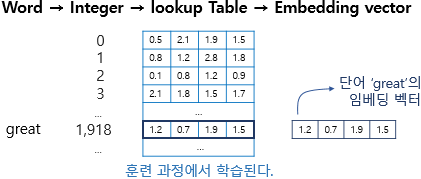

참고: https://wikidocs.net/64779

In [ ]:
# torch.nn.Embedding 예시
lookup_table = nn.Embedding(vocab_size, embedding_dim=10)   # 각 단어마다 10차원 벡터로 매핑
print(f"Lookup table: {lookup_table}")

word_id = word2idx["freedom"]
print(f"'freedom'의 고유번호(인덱스): {word_id}")
print(f"'freedom'의 임베딩 벡터: {lookup_table(torch.tensor(word_id))}")    # 임베딩 층의 입력은 텐서 형태여야 한다

Lookup table: Embedding(78, 10)
'freedom'의 고유번호(인덱스): 46
'freedom'의 임베딩 벡터: tensor([ 0.8016,  1.0840,  1.3671,  1.4151,  1.1872, -1.1876,  0.2077,  0.0725,
        -1.7465, -0.1383], grad_fn=<EmbeddingBackward0>)


>차례대로 두 가지 Word2Vec 모델을 구현한다.
>- ```self.embeddings```: 임베딩 층(`nn.Embedding`)을 활용하여 단어 인덱스로 구성된 입력을 `embedding_dim` 차원의 벡터로 변환
>- ```self.linear```: 가중치(weight) 행렬을 곱하고 편항치(bias)를 더하는 선형 층. `embedding_dim` 차원의 벡터를 `vocab_size` 차원의 벡터로 변환

In [ ]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embeddings = self.embeddings(inputs)
        embeddings = torch.sum(embeddings, dim=1)   # 주변 단어 임베딩 벡터들을 sum pooling 하여 하나의 임베딩 벡터로 만듦
        output = self.linear(embeddings)
        return output

In [ ]:
class SkipGram(nn.Module):
    def __init__(self, vocab_size, embedding_dim=256):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        embeddings = self.embeddings(inputs)
        output = self.linear(embeddings)
        return output

In [ ]:
# 모델 선언
cbow = CBOW(vocab_size)
skipgram = SkipGram(vocab_size)

print(cbow)
print()
print(skipgram)

CBOW(
  (embeddings): Embedding(78, 256)
  (linear): Linear(in_features=256, out_features=78, bias=True)
)

SkipGram(
  (embeddings): Embedding(78, 256)
  (linear): Linear(in_features=256, out_features=78, bias=True)
)


## 2. Word2Vec 학습 및 추론하기

### 2-1. 학습하기

> 다음과 같이 hyperparameter를 세팅하고 ```DataLoader``` 객체를 만든다.
>
> `DataLoader`는 `Dataset`을 배치화하는 역할을 수행한다.

In [ ]:
batch_size = 4
learning_rate = 1e-3
num_epochs = 100
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Device: {device}")

cbow_loader = DataLoader(cbow_set, batch_size=batch_size)
skipgram_loader = DataLoader(skipgram_set, batch_size=batch_size)

Device: cpu


Epoch: 13| Step   500	| Loss: 2.272
Epoch: 25| Step  1000	| Loss: 1.080
Epoch: 38| Step  1500	| Loss: 0.551
Epoch: 50| Step  2000	| Loss: 0.378
Epoch: 63| Step  2500	| Loss: 0.264
Epoch: 75| Step  3000	| Loss: 0.217
Epoch: 88| Step  3500	| Loss: 0.174
Epoch: 100| Step  4000	| Loss: 0.153


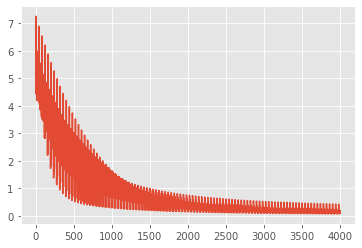

In [ ]:
cbow.train()
cbow = cbow.to(device)
optimizer = torch.optim.SGD(cbow.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

step = 0
steps = []
loss_list = []

for e in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(cbow_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        output = cbow(x)

        optimizer.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        step += 1
        steps.append(step)
        loss_list.append(loss.item())

        if step % 500 == 0 and i != 0:
            print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

plt.plot(steps, loss_list)

Epoch:  4| Step   500	| Loss: 4.310
Epoch:  7| Step  1000	| Loss: 4.025
Epoch: 10| Step  1500	| Loss: 3.918
Epoch: 13| Step  2000	| Loss: 3.714
Epoch: 16| Step  2500	| Loss: 3.559
Epoch: 19| Step  3000	| Loss: 3.418
Epoch: 23| Step  3500	| Loss: 7.111
Epoch: 26| Step  4000	| Loss: 3.180
Epoch: 29| Step  4500	| Loss: 3.072
Epoch: 32| Step  5000	| Loss: 3.084
Epoch: 35| Step  5500	| Loss: 2.993
Epoch: 38| Step  6000	| Loss: 2.922
Epoch: 41| Step  6500	| Loss: 2.845
Epoch: 45| Step  7000	| Loss: 3.837
Epoch: 48| Step  7500	| Loss: 2.756
Epoch: 51| Step  8000	| Loss: 2.708
Epoch: 54| Step  8500	| Loss: 2.718
Epoch: 57| Step  9000	| Loss: 2.664
Epoch: 60| Step  9500	| Loss: 2.629
Epoch: 63| Step 10000	| Loss: 2.578
Epoch: 67| Step 10500	| Loss: 3.020
Epoch: 70| Step 11000	| Loss: 2.596
Epoch: 73| Step 11500	| Loss: 2.536
Epoch: 76| Step 12000	| Loss: 2.528
Epoch: 79| Step 12500	| Loss: 2.502
Epoch: 82| Step 13000	| Loss: 2.464
Epoch: 85| Step 13500	| Loss: 2.442
Epoch: 89| Step 14000	| Loss

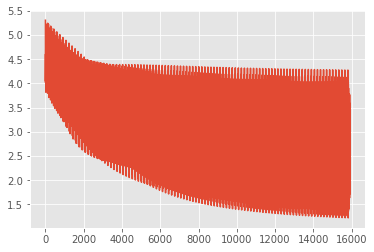

In [ ]:
skipgram.train()
skipgram = skipgram.to(device)
optimizer = torch.optim.SGD(skipgram.parameters(), lr=learning_rate)
loss_function = nn.CrossEntropyLoss()

step = 0
steps = []
loss_list = []

for e in range(num_epochs):
    running_loss = 0.0
    for i, batch in enumerate(skipgram_loader):
        x, y = batch
        x, y = x.to(device), y.to(device)
        output = skipgram(x)

        optimizer.zero_grad()
        loss = loss_function(output, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        step += 1
        steps.append(step)
        loss_list.append(loss.item())

        if step % 500 == 0 and i != 0:
            print(f'Epoch: {e+1:2d}| Step {step:5d}\t| Loss: {running_loss/(i):.3f}')

plt.plot(steps, loss_list)

### 2-2. 추론하기

> 학습된 각 모델을 이용하여 테스트 단어들의 word embedding을 확인한다.

In [ ]:
# 테스트 단어
test_words = ["freedom", "liberties", "forever", "ratification"]

for word in test_words:
    input_id = torch.LongTensor([word2idx[word]]).to(device)    # 고유번호로 변환
    emb = skipgram.embeddings(input_id)                         # 임베딩 층만 활용

    print(f"Word: {word}")
    print(emb.squeeze(0)[:10])  # squeeze(0)을 활용해 2D -> 1D 텐서로 변환해주고, [:10]으로 slicing 하여 첫 10차원만 출력한다.

Word: freedom
tensor([ 0.3866, -1.4081,  0.5992,  0.2338,  0.1283,  0.9066, -0.3934, -0.3256,
        -0.0764,  1.0018], grad_fn=<SliceBackward0>)
Word: liberties
tensor([ 0.3116, -0.0192,  0.6585,  0.8382, -0.1799,  0.3739, -0.1677, -0.1601,
         2.8838,  0.9424], grad_fn=<SliceBackward0>)
Word: forever
tensor([ 0.8754,  0.5991,  0.0421, -1.0823,  0.0665,  0.5407, -0.2894, -1.6402,
         1.1191,  1.4962], grad_fn=<SliceBackward0>)
Word: ratification
tensor([-0.4782, -1.5124,  1.5285,  0.1859, -0.4876,  0.0662,  0.3597, -1.2626,
         0.6129,  0.5822], grad_fn=<SliceBackward0>)


> 주어진 단어와 유사한 단어들을 출력한다.
>
> 유사도를 측정하기 위해서는 주어진 단어 벡터 `query_emb`와 모든 단어 벡터 간의 내적 연산(dot product)을 통해 가장 높은 점수를 가진 단어가 유사도가 높다고 판단한다.
>
> `torch.matmul(input, other)`로 두 행렬 `input`과 `other`의 내적 연산을 구할 수 있고,
>
> `torch.topk(input, k)`로 내적 값 `input`의 top `k` 가장 유사한 단어들과 그것들의 점수를 추출할 수 있다.

In [ ]:
def most_similar(query_word, top_k=5):
    query_id = torch.LongTensor([word2idx[query_word]]).to(device)
    query_embedding = skipgram.embeddings(query_id)   # (1, embedding_dim)
    skipgram_embeddnigs = skipgram.embeddings.weight  # (vocab_size, embedding_dim)

    scores = torch.matmul(query_embedding, skipgram_embeddings.T)  # (1, embedding_dim) x (embedding_dim, vocab_size) = (1, vocab_size)
    scores = scores.squeeze(0)  # (vocab_size)

    top_k_scores, top_k_ids = torch.topk(scores, top_k)
    top_k_scores = [score.item() for score in top_k_scores]     # .item()을 통해 data 값만 저장
    top_k_words = [idx2word[word_id.item()] for word_id in top_k_ids][1:]   # 고유번호를 단어로 변환. 제일 가까운 단어(0번째 인덱스)는 query 단어임으로 제외

    return list(zip(top_k_words, top_k_scores))

In [ ]:
# 단어 "freedom"과 유사한 단어들을 출력
query = "freedom"
print(f"'freedom'과 유사한 단어들과 점수: {most_similar(query)}")

'freedom'과 유사한 단어들과 점수: [('to', 287.74957275390625), ('confirm', 36.24120330810547), ('we', 35.76811218261719), ('charter', 33.05973434448242)]


## 3. Gensim 패키지를 활용해 Word Embedding을 시각화하여 분석하기

> 위의 단원에서는 충분한 데이터로 학습하지 못했기 때문에 추론할 때 유사한 단어들을 잘 추출해내지 못했다. 그러므로 사전 학습된 word embedding 모델로 추론을 하고 시각화 하여 정성적인 평가를 해보고자 한다.
>
> Gensim 패키지에는 다양한 Word2Vec 모델들이 다음과 같이 존재한다.

In [ ]:
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


> 본 실습에서는 'glove-wiki-gigaword-300'를 로드해서 사용한다.
>
> 'glove-wiki-gigaword-300'는 20억개의 트윗, 270억개의 토큰으로 학습되어 120만개의 vocab으로 구성되어 있다. 학습 방법은 [GloVe: Global Vectors for Word Representation (Pennington et al., 2014)](https://nlp.stanford.edu/pubs/glove.pdf) 논문에서 제안하였다.

In [ ]:
# 사전 학습된 GloVe 임베딩 로드
w2v_vectors = gensim.downloader.load('glove-wiki-gigaword-300')

[==================================================] 100.0% 376.1/376.1MB downloaded


> Gensim에서는 `most_similar(positive, negative, topn=10)` 함수를 제공해준다.
>
> `positive` 단어만 주어졌을 때, `topn`개의 유사한 단어들을 추출한다.
>
> `negative` 단어가 주어지면 `topn`개의 유사하지 않은 (negative 유사도가 높은) 단어들을 추출한다.
>
> 충분한 데이터로 사전 학습된 결과, "freedom"과 유사한 단어들을 잘 추출하는 것을 확인할 수 있다.

In [ ]:
# "freedom"과 유사한 top k 단어들 출력
w2v_vectors.most_similar("freedom", topn=5)

[('freedoms', 0.6644782423973083),
 ('liberty', 0.6439749598503113),
 ('democracy', 0.6147063970565796),
 ('rights', 0.6090532541275024),
 ('liberties', 0.5701642632484436)]

In [ ]:
# "freedom"과 제일 유사하지 않은 top k 단어들 출력 (반의어가 아닌 제일 높은 negative cosine similarity 기준이다.)
w2v_vectors.most_similar(negative="freedom", topn=5)

[('23aou94', 0.4356203079223633),
 ('http://www.ecb.int', 0.4224078953266144),
 ('27aou94', 0.4219847321510315),
 ('fazilah', 0.42036306858062744),
 ('str94', 0.4192894697189331)]

In [ ]:
# positive와 negative를 리스트로 주면 해당 단어 임베딩을 더하거나 뺄 수 있다.
w2v_vectors.most_similar(positive=['woman', 'king'], topn=10)

[('mother', 0.6679739952087402),
 ('man', 0.6607178449630737),
 ('queen', 0.6474451422691345),
 ('wife', 0.6157330274581909),
 ('daughter', 0.6060694456100464),
 ('girl', 0.5874864459037781),
 ('father', 0.5838301181793213),
 ('her', 0.5807107090950012),
 ('husband', 0.5760871767997742),
 ('she', 0.5645872950553894)]

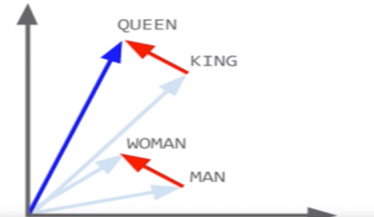

> Word embedding은 linear substructure라는 특징을 가지고 있는데,
>
> "king" 벡터와 "woman" 벡터를 더하고 "man" 벡터를 빼면 "queen" 벡터를 구할 수 있다.

In [ ]:
result = w2v_vectors.most_similar(positive=['woman', 'king'], negative=['man'])
print("{}: {:.4f}".format(*result[0]))

queen: 0.6713


> 위의 코드를 함수화하여 word analogy를 다양한 단어들에 적용해 볼 수 있다.

In [ ]:
def analogy(x1, x2, y1):
    result = w2v_vectors.most_similar(positive=[y1, x2], negative=[x1])
    return result[0][0]

In [ ]:
analogy('japan', 'japanese', 'australia')

'australian'

In [ ]:
analogy('good', 'fantastic', 'bad')

'horrible'

> PCA (Principle Component Analysis)는 고차원의 벡터를 저차원 공간으로 매핑을 시키는 기법 중 하나이다. PCA를 활용해서 단어 벡터들을 2차원으로 변환하여 시각화하고자 한다.

In [ ]:
def display_pca_scatterplot(model, words=None, sample=0):
    if words == None:
        if sample > 0:  # sample이 주어지면 랜덤 샘플링으로 단어들을 뽑아낸다.
            words = np.random.choice(list(model.vocab.keys()), sample)
        else:
            words = [ word for word in model.vocab ]

    word_vectors = np.array([model[w] for w in words])
    twodim = PCA().fit_transform(word_vectors)[:,:2]    # 2차원 벡터로 변환

    plt.figure(figsize=(12,12))
    plt.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c='r')    # x값과 y값을 scatterplot에 찍어준다.
    for word, (x,y) in zip(words, twodim):
        plt.text(x+0.05, y+0.05, word)  # 단어 텍스트를 plot point에서 0.05 위로, 0.05 오른쪽에 배치한다.

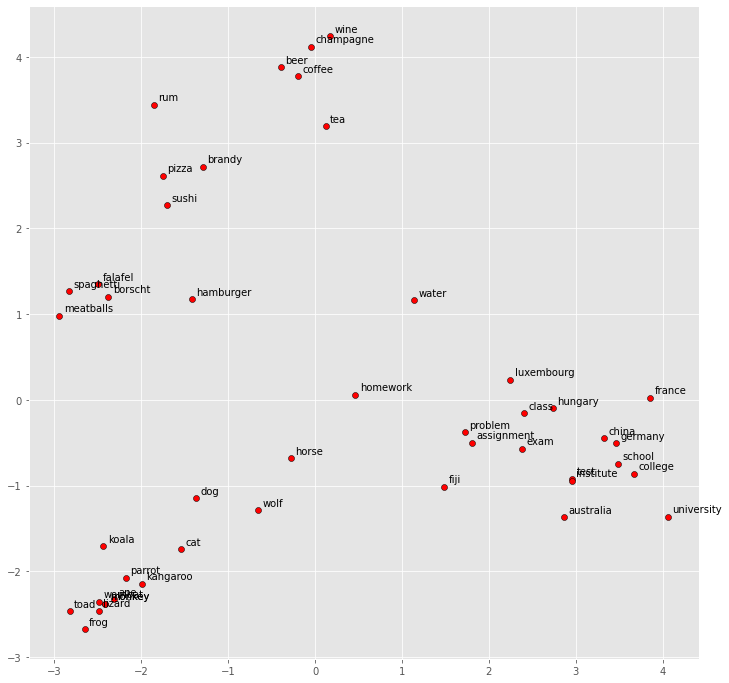

In [ ]:
display_pca_scatterplot(w2v_vectors,
                        ['coffee', 'tea', 'beer', 'wine', 'brandy', 'rum', 'champagne', 'water',
                         'spaghetti', 'borscht', 'hamburger', 'pizza', 'falafel', 'sushi', 'meatballs',
                         'dog', 'horse', 'cat', 'monkey', 'parrot', 'koala', 'lizard',
                         'frog', 'toad', 'monkey', 'ape', 'kangaroo', 'wombat', 'wolf',
                         'france', 'germany', 'hungary', 'luxembourg', 'australia', 'fiji', 'china',
                         'homework', 'assignment', 'problem', 'exam', 'test', 'class',
                         'school', 'college', 'university', 'institute'])

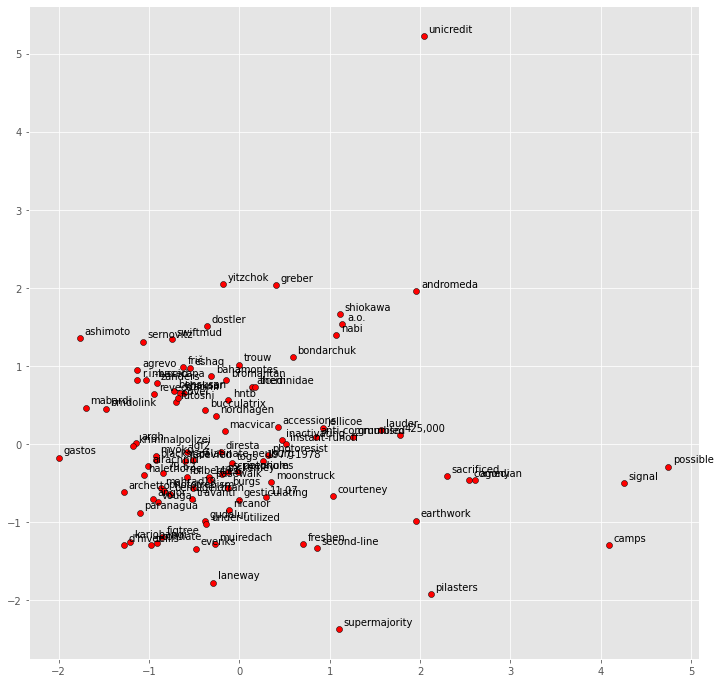

In [ ]:
# 샘플링으로 랜덤한 단어들을 시각화
display_pca_scatterplot(w2v_vectors, sample=100)